<a href="https://colab.research.google.com/github/shraddha-an/nlp/blob/main/StumbleUpon_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1) Data Preprocessing**

In [1]:
# Importing libraries
# Data Manipulation/Handling
import pandas as pd, numpy as np

# Simple NLP preprocessing
from gensim.utils import simple_preprocess

# Manipulating JSON objects
from json import loads

# Plotting
import matplotlib.pyplot as plt, seaborn as sb

# Disabling warnings
import warnings
warnings.filterwarnings('ignore')

## **1) Data Preprocessing**


In [2]:
# Importing datasets
train = pd.read_csv('train.tsv', delimiter = '\t')
test = pd.read_csv('test.tsv', delimiter = '\t')

# Replacing every '?' with NaNs
# Train column
for c in train.columns:
    train[c] = train[c].apply(lambda x: np.nan if x == '?' else x)

# Test column
for c in test.columns:
    test[c] = test[c].apply(lambda x: np.nan if x == '?' else x)

# Extracting the JSON object from string
train['text'] = train['boilerplate'].apply(lambda x: loads(x)['body'] if loads(x)['body'] != ' ' and loads(x)['body'] != None  else loads(x)['url'])
test['text'] = test['boilerplate'].apply(lambda x: loads(x)['body'] if loads(x)['body'] != ' ' and loads(x)['body'] != None else loads(x)['url'])

test.head(3)

# Looking at columns that contain NaN
train.isna().sum()


url                                  0
urlid                                0
boilerplate                          0
alchemy_category                  2342
alchemy_category_score            2342
avglinksize                          0
commonlinkratio_1                    0
commonlinkratio_2                    0
commonlinkratio_3                    0
commonlinkratio_4                    0
compression_ratio                    0
embed_ratio                          0
framebased                           0
frameTagRatio                        0
hasDomainLink                        0
html_ratio                           0
image_ratio                          0
is_news                           2843
lengthyLinkDomain                    0
linkwordscore                        0
news_front_page                   1248
non_markup_alphanum_characters       0
numberOfLinks                        0
numwords_in_url                      0
parametrizedLinkRatio                0
spelling_errors_ratio    

In [3]:
# Considering only the article and the target label
ds = train[['text', 'label']]
df = test[['text']]

# Dropping the missing text rows
ds.dropna(inplace = True)
df.dropna(inplace = True)

# Applying gensim's simple_preprocess method to preprocess text
ds['text'] = ds['text'].apply(lambda x: ' '.join(simple_preprocess(x)))
df['text'] = df['text'].apply(lambda x: ' '.join(simple_preprocess(x)))

# Splitting into train & test subsets
X_train = ds.iloc[:, 0].values
y_train = ds.iloc[:, 1].values

X_test = df.iloc[:, 0].values


## **2) Tokenization**

In [4]:
# Tokenization with Keras
# Some parameters for embedding layer & tokenization
vocab_size = 2100
output_dim = 50
sequence_length = 300

# Tokenization - representing words with their indices
from keras.preprocessing.text import Tokenizer

tk = Tokenizer(num_words = vocab_size)
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

word_dict = tk.word_index

# Padding all sequences with zeros to make them of uniform length
from keras.preprocessing.sequence import pad_sequences

X_train_seq = pad_sequences(X_train_seq, padding = 'post', maxlen = sequence_length, truncating = 'post')
X_test_seq = pad_sequences(X_test_seq, padding = 'post', maxlen = sequence_length, truncating = 'post')


## **3) Classification Neural Network**

In [5]:
# Building the Classification ANN
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = output_dim, input_length = sequence_length))
model.add(Flatten())

model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

# Looking at the model's summary
model.summary()

history = model.fit(X_train_seq, y_train, epochs = 10, batch_size = 1024, verbose = 1)

# Predictions on test set
y_pred = model.predict_classes(X_test_seq)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 50)           105000    
_________________________________________________________________
flatten (Flatten)            (None, 15000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 15001     
Total params: 120,001
Trainable params: 120,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
8/8 [==============================] - 1s 61ms/step - loss: 0.6840 - accuracy: 0.5632
Epoch 2/10
8/8 [==============================] - 0s 56ms/step - loss: 0.6194 - accuracy: 0.6493
Epoch 3/10
8/8 [==============================] - 0s 57ms/step - loss: 0.5528 - accuracy: 0.7433
Epoch 4/10
8/8 [==============================] - 0s 56ms/step - loss: 0.5019 - accuracy:

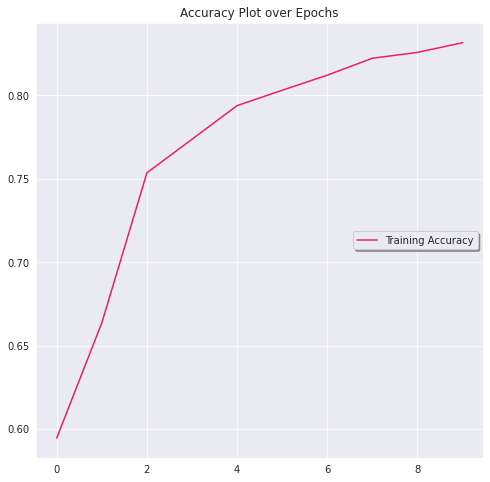

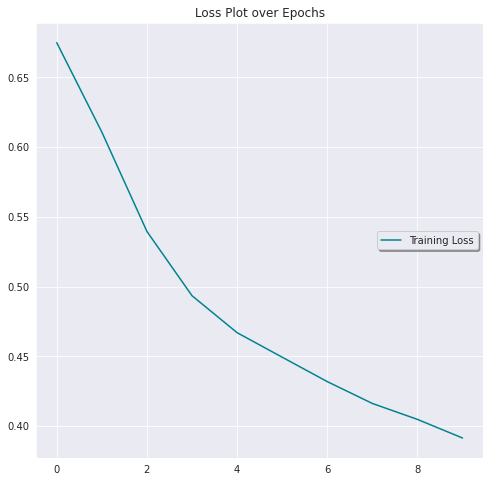

In [6]:
# Plotting Accuracy & Loss over epochs
sb.set_style('darkgrid')

# 1) Accuracy
plt.figure(figsize = (8, 8))
plt.plot(history.history['accuracy'], label = 'Training Accuracy', color = '#E91E63')
plt.legend(shadow = True, loc = 'center right')
plt.title('Accuracy Plot over Epochs')
plt.show()

# 2) Loss
plt.figure(figsize = (8, 8))
plt.plot(history.history['loss'], label = 'Training Loss', color = '#00838F')
plt.legend(shadow = True, loc = 'center right')
plt.title('Loss Plot over Epochs')
plt.show()

## **4) Saving Output CSV**

In [7]:
# Making a sample submission CSV
pd.DataFrame({"urlid":list(test['urlid']),
              "label": y_pred.reshape(-1)}).to_csv("evergreen_final.csv",
                                                   index = False,
                                                   header = True)
              
# Download it to local machine and upload it in the competition. Uncomment to download.
from google.colab import files
#files.download('evergreen_final.csv') 

## **5) Evaluating Model's performance**

In this part, I will divide the training data into train/validation data with an 80:20 split. 

This is deliberately done so as to take a look at the model's performance metrics such as accuracy, precision and recall as the test set labels are not provided in the StumbleUpon Evergreen Classification Challenge.

In [8]:
# Dividing into train & validation datasets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state = 0, test_size = 0.2)

# Again, repeating the tokenization steps
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_valid_seq = tk.texts_to_sequences(X_valid)

# And padding all sequences with zeros to make them of uniform length
X_train_seq = pad_sequences(X_train_seq, padding = 'post', maxlen = sequence_length, truncating = 'post')
X_valid_seq = pad_sequences(X_valid_seq, padding = 'post', maxlen = sequence_length, truncating = 'post')


Epoch 1/10
6/6 - 0s - loss: 0.5387 - accuracy: 0.7294
Epoch 2/10
6/6 - 0s - loss: 0.4867 - accuracy: 0.7777
Epoch 3/10
6/6 - 0s - loss: 0.4607 - accuracy: 0.7950
Epoch 4/10
6/6 - 0s - loss: 0.4412 - accuracy: 0.8066
Epoch 5/10
6/6 - 0s - loss: 0.4273 - accuracy: 0.8137
Epoch 6/10
6/6 - 0s - loss: 0.4081 - accuracy: 0.8259
Epoch 7/10
6/6 - 0s - loss: 0.3929 - accuracy: 0.8337
Epoch 8/10
6/6 - 0s - loss: 0.3771 - accuracy: 0.8470
Epoch 9/10
6/6 - 0s - loss: 0.3652 - accuracy: 0.8509
Epoch 10/10
6/6 - 0s - loss: 0.3516 - accuracy: 0.8556


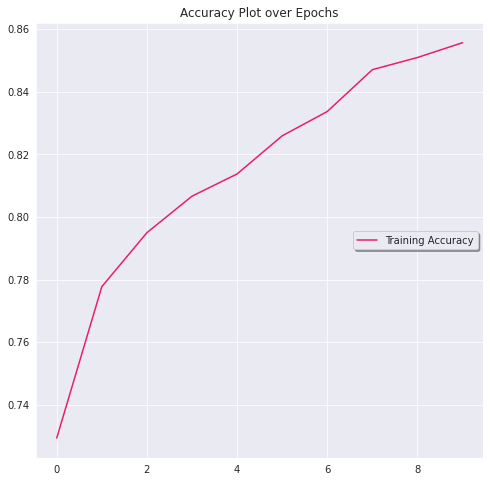

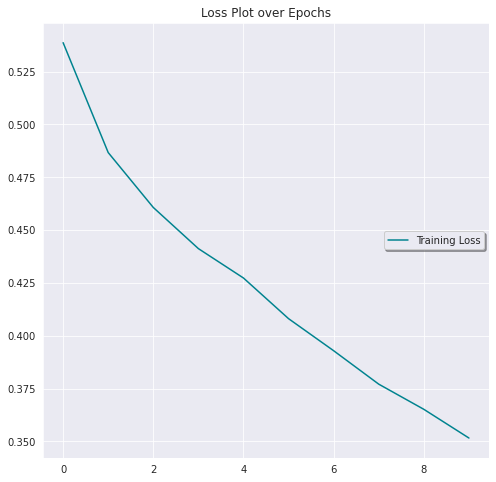

In [9]:
# Training the model again
history_validation = model.fit(X_train_seq, y_train, epochs = 10, batch_size = 1024, verbose = 2)

# Predictions on test set
y_pred_validation = model.predict_classes(X_valid_seq)

# Plotting the change in accuracy and loss over the epochs
# 1) Accuracy
plt.figure(figsize = (8, 8))
plt.plot(history_validation.history['accuracy'], label = 'Training Accuracy', color = '#E91E63')
plt.legend(shadow = True, loc = 'center right')
plt.title('Accuracy Plot over Epochs')
plt.show()

# 2) Loss
plt.figure(figsize = (8, 8))
plt.plot(history_validation.history['loss'], label = 'Training Loss', color = '#00838F')
plt.legend(shadow = True, loc = 'center right')
plt.title('Loss Plot over Epochs')
plt.show()

### **Classification Metrics**

In [13]:
# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report as cr

accuracy = accuracy_score(y_valid, y_pred_validation)
precision = precision_score(y_valid, y_pred_validation)
recall = recall_score(y_valid, y_pred_validation)

classification_report = cr(y_valid, y_pred_validation)

print('Accuracy: {}\nPrecision: {}\nRecall: {}\n'.format(accuracy, precision, recall))
print('\n', classification_report)

Accuracy: 0.7903989181879648
Precision: 0.8465045592705167
Recall: 0.7271540469973891


               precision    recall  f1-score   support

           0       0.75      0.86      0.80       713
           1       0.85      0.73      0.78       766

    accuracy                           0.79      1479
   macro avg       0.80      0.79      0.79      1479
weighted avg       0.80      0.79      0.79      1479

